In [6]:
%%writefile funcs.hpp

int add(int i, int j);

Overwriting funcs.hpp


In [7]:
%%writefile funcs.cpp

int add(int i, int j) {
    return i + j;
};

Overwriting funcs.cpp


In [8]:
%%writefile wrap1.cpp
#include <pybind11/pybind11.h>
#include "funcs.hpp"

namespace py = pybind11;
using namespace pybind11::literals;

PYBIND11_MODULE(example, m) {
    m.doc() = "pybind11 example plugin"; // optional module docstring

    m.def("add", &add, "A function which adds two numbers",
          "i"_a, "j"_a=2);
}

Overwriting wrap1.cpp


In [35]:
%%bash
c++ -O3 -Wall -shared -std=c++11 -fPIC `python3 -m pybind11 --includes` wrap1.cpp -o wrap1`python3-config --extension-suffix`

In [36]:
import wrap1

In [37]:
wrap1.add(i=2)

4

In [33]:
help(wrap1)

Help on module wrap1:

NAME
    wrap1 - pybind11 example plugin

FUNCTIONS
    add(...) method of builtins.PyCapsule instance
        add(i: int=1, j: int=2) -> int
        
        A function which adds two numbers

FILE
    /home/olszewskip/Desktop/git-repos/MDFS_playground/python/scheduler/example1/wrap1.cpython-35m-x86_64-linux-gnu.so




---
07.02

In [10]:
%%writefile pi.cpp
/*
<%
setup_pybind11(cfg)
%>
*/
#include <pybind11/pybind11.h>

namespace py = pybind11;

double compute_pi(int n) {
    
    double step = 1.0/n;
    double pi = 0;

    double x;
    for(int i = 0 ; i < n ; i++){
        x = (i + 0.5) * step;
        pi += 4.0 / (1 + x*x);
    }
    
    pi *= step;
    return pi;
}


PYBIND11_MODULE(pi, m) {
    m.def("compute_pi", &compute_pi);
}

Overwriting pi.cpp


In [11]:
import cppimport

In [12]:
pi = cppimport.imp("pi")

In [13]:
%timeit pi.compute_pi(1000000)

4.37 ms ± 60.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%%writefile openmp_pi.cpp
/*
<%
setup_pybind11(cfg)
cfg['compiler_args'] = ['-fopenmp']
cfg['linker_args'] = ['-fopenmp']
%>
*/
#include <pybind11/pybind11.h>
#include <omp.h>

namespace py = pybind11;

double compute_pi(int n) {
    
    double step = 1.0/n;
    double pi = 0;
    
    omp_set_num_threads(2);
    #pragma omp parallel
    {
        double x;
        #pragma omp for reduction(+:pi)
        for(int i = 0 ; i < n ; i++){
            x = (i + 0.5) * step;
            pi += 4.0 / (1 + x*x);
        }
    }
    
    pi *= step;
    return pi;
}


PYBIND11_MODULE(openmp_pi, m) {
    m.def("compute_pi", &compute_pi);
}

Overwriting openmp_pi.cpp


In [6]:
# m.def("compute_pi", &compute_pi, py::call_guard<py::gil_scoped_release>() )?

In [1]:
import cppimport

In [2]:
# cppimport.force_rebuild()
openmp_pi = cppimport.imp("openmp_pi")

In [3]:
openmp_pi.compute_pi(10)

3.1424259850010987

In [4]:
%timeit openmp_pi.compute_pi(1000000)

2.35 ms ± 3.95 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%%writefile takietam.cpp
/*
<%
setup_pybind11(cfg)
%>
*/
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
namespace py = pybind11;

void sayhi() {
    py::print("hi!");
}
        
PYBIND11_MODULE(takietam, module) {
    module.def("sayhi", &sayhi);
}

Overwriting takietam.cpp


In [1]:
import cppimport

In [2]:
cppimport.set_quiet(True)

In [3]:
takietam = cppimport.imp("takietam")

In [4]:
takietam.sayhi()

hi!


In [1]:
%%writefile np1.cpp
/*
<%
setup_pybind11(cfg)
%>
*/
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
namespace py = pybind11;

void print_info(py::array_t<int> input1) {
    py::buffer_info buf1 = input1.request();
    py::print("ptr:", buf1.ptr);
    py::print("itemsize:", buf1.itemsize);
    py::print("format:", buf1.format);
    py::print("ndim:", buf1.ndim);
    for (int i = 0; i < buf1.shape.size(); i++) {
      py::print(i, "shape:", buf1.shape[i]);
    }
    for (int i = 0; i < buf1.strides.size(); i++) {
      py::print(i, "stride:", buf1.strides[i]);
    }
    
    int *ptr = (int *) buf1.ptr;
    int element_count = 1;
    for (auto r: buf1.shape) {
      element_count *= r;
    }
    for (int i = 0; i < element_count; i++) {
        py::print(i, "element:", *ptr++);
    }

}
        
PYBIND11_MODULE(np1, module) {
    module.def("print_info", &print_info);
}

Overwriting np1.cpp


In [2]:
import cppimport
np1 = cppimport.imp("np1")
import numpy as np

In [4]:
np1.print_info([[11,12,13],[14,15,16]])

ptr: <capsule object NULL at 0x7fc2a80dafc0>
itemsize: 4
format: i
ndim: 2
0 shape: 2
1 shape: 3
0 stride: 12
1 stride: 4
0 element: 11
1 element: 12
2 element: 13
3 element: 14
4 element: 15
5 element: 16


In [9]:
%%writefile np2.cpp
/*
<%
setup_pybind11(cfg)
%>
*/
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
namespace py = pybind11;

void double_elems(py::array_t<int> input) {
    
    py::buffer_info buf = input.request();
    int *ptr = (int *) buf.ptr;
    
    int element_count = 1;
    for (auto r: buf.shape) {
      element_count *= r;
    }
    for (int i = 0; i < element_count; i++) {
        *ptr++ *= 2;
    }
}
        
PYBIND11_MODULE(np2, module) {
    module.def("double_elems", &double_elems);
}

Overwriting np2.cpp


In [1]:
import cppimport
np2 = cppimport.imp("np2")
import numpy as np

In [2]:
my_array = np.array([[11,12,13],[14,15,16]], dtype='int32') # dtype!!!
np2.double_elems(my_array)

In [3]:
my_array

array([[22, 24, 26],
       [28, 30, 32]], dtype=int32)

In [4]:
%%writefile np3.cpp
/*
<%
setup_pybind11(cfg)
cfg['compiler_args'] = ['-fopenmp']
cfg['linker_args'] = ['-fopenmp']
%>
*/
#include <pybind11/pybind11.h>
// #include <pybind11/numpy.h>
#include <omp.h>

#define NUM_THREADS 2
namespace py = pybind11;

double compute_pi(int n) {
    
    double step = 1.0 / n;
    double pi_parts[NUM_THREADS];
    omp_set_num_threads(NUM_THREADS);
    
    int nthreads;
    
    #pragma omp parallel
    {
        int id = omp_get_thread_num();
        pi_parts[id] = 0.0;
        int nthrds = omp_get_num_threads();
        if (id == 0) nthreads = nthrds;
        double x;
        for (int i=id; i<n; i=i+nthrds) {
            x = (i + 0.5) * step;
            pi_parts[id] += 4.0 / (1.0 + x*x);
        }
    }
    
    double pi = 0.0;
    for (int i=0; i<nthreads; i++){
        pi += pi_parts[i] * step;
    }
    return pi;
}


PYBIND11_MODULE(np3, m) {
    m.def("compute_pi", &compute_pi);
}

Overwriting np3.cpp


In [5]:
import cppimport
np3 = cppimport.imp("np3")
import numpy as np

In [6]:
np3.compute_pi(10000)

3.141592654423132

In [6]:
%%writefile np3.cpp
/*
<%
setup_pybind11(cfg)
cfg['compiler_args'] = ['-fopenmp']
cfg['linker_args'] = ['-fopenmp']
%>
*/
#include <omp.h>
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>

#define NUM_THREADS 2
namespace py = pybind11;

void double_elems(py::array_t<int> input){
     
    py::buffer_info buf = input.request();
    int *ptr = (int *) buf.ptr;
    
    int element_count = 1;
    for (auto r: buf.shape) {
      element_count *= r;
    }
    
    omp_set_num_threads(NUM_THREADS);
    #pragma omp parallel
    {
        int id = omp_get_thread_num();
        int nthrds = omp_get_num_threads();
        for (int i = id; i < element_count; i += nthrds) {
            ptr[i] *= 2;
        }
    }
     
}
        
PYBIND11_MODULE(np3, module) {
    module.def("double_elems", &double_elems);
}

Overwriting np3.cpp


In [1]:
import cppimport
np3 = cppimport.imp("np3")
import numpy as np

In [3]:
my_array = np.array(range(100), dtype = 'int32')
np3.double_elems(my_array)

In [4]:
my_array

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198], dtype=int32)

In [8]:
%%writefile np4.cpp
/*
<%
setup_pybind11(cfg)
cfg['compiler_args'] = ['-fopenmp']
cfg['linker_args'] = ['-fopenmp']
%>
*/
#include <omp.h>
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>

#define NUM_THREADS 2
namespace py = pybind11;

void double_elems(py::array_t<int> input){
     
    py::buffer_info buf = input.request();
    int *ptr = (int *) buf.ptr;
    
    int element_count = 1;
    for (auto r: buf.shape) {
      element_count *= r;
    }
    
    omp_set_num_threads(NUM_THREADS);
    #pragma omp parallel for schedule(static, 1)
    for (int i = 0; i < element_count; i++) {
        ptr[i] *= 2;
    }
     
}
        
PYBIND11_MODULE(np4, module) {
    module.def("double_elems", &double_elems);
}

Overwriting np4.cpp


In [9]:
import cppimport
np4 = cppimport.imp("np4")
import numpy as np

In [10]:
my_array = np.array(range(10), dtype = 'int32')
np3.double_elems(my_array)
my_array

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18], dtype=int32)

In [ ]:
%%writefile np5.cpp
/*
<%
setup_pybind11(cfg)
cfg['compiler_args'] = ['-fopenmp']
cfg['linker_args'] = ['-fopenmp']
%>
*/
#include <cmath>
#include <omp.h>
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>

#define NUM_THREADS 2
namespace py = pybind11;

int contingency(const int divisions, const int N, py::array_t<int> input1, py::array_t<int> input2){
    
    double l = std::log(3);
    py::print(l);
    
    int contingency_m[divisions][divisions] = {};
    
    for (int i = 0; i < divisions; i++)
        for (int j = 0; j < divisions; j++)
            py::print(contingency_m[i][j]);

    
    py::buffer_info buf1 = input1.request();
    py::buffer_info buf2 = input2.request();
    int *ptr1 = (int *) buf1.ptr;
    int *ptr2 = (int *) buf2.ptr;
    
    
    omp_set_num_threads(NUM_THREADS);
    
    int prod = 0;
    
    #pragma omp parallel for reduction(+:prod)
    for (int i = 0; i < N; i++) {
        prod += ptr1[i] * ptr2[i];
    }
    
    return prod;
}
        
PYBIND11_MODULE(np5, module) {
    module.def("contingency", &contingency);
}

In [1]:
%%writefile np6.cpp
/*
<%
setup_pybind11(cfg)
cfg['compiler_args'] = ['-fopenmp']
cfg['linker_args'] = ['-fopenmp']
%>
*/
#include <omp.h>
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>

#define NUM_THREADS 2
namespace py = pybind11;

int scalar_prod(py::array_t<int> input1, py::array_t<int> input2){
    
    py::buffer_info buf1 = input1.request();
    py::buffer_info buf2 = input2.request();
    int *ptr1 = (int *) buf1.ptr;
    int *ptr2 = (int *) buf2.ptr;
    
    int element_count = 1;
    for (auto r: buf1.shape) {
      element_count *= r;
    }
    
    omp_set_num_threads(NUM_THREADS);
    
    int prod = 0;
    
    #pragma omp parallel
    {
        #pragma omp for reduction(+:prod)
        for (int i = 0; i < element_count; i++) {
            prod += ptr1[i] * ptr2[i];
        }
    }
    
    return prod;
}
        
PYBIND11_MODULE(np6, module) {
    module.def("scalar_prod", &scalar_prod);
}

Overwriting np6.cpp


In [2]:
import cppimport
np6 = cppimport.imp("np6")
import numpy as np

In [3]:
N = 1000
my_array1 = np.ones(N, dtype='int32') * 7
my_array2 = np.ones(N, dtype='int32') * 5

In [10]:
%%timeit
np.sum(my_array1 * my_array2)

5.51 µs ± 85.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
%%timeit
np6.scalar_prod(my_array1, my_array2) # NUM_THREADS 1

2.78 µs ± 117 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [5]:
%%timeit
np6.scalar_prod(my_array1, my_array2) # NUM_THREADS 2

3.17 µs ± 101 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
%%writefile mpi4py_openmp.py
import numpy as np
np.random.seed(123)

from mpi4py import MPI
comm = MPI.COMM_WORLD
comm.Barrier()
time0 = MPI.Wtime()
size = comm.Get_size()
rank = comm.Get_rank()

---
18.02

In [1]:
%%writefile buffer_info.cpp
/*
<%
setup_pybind11(cfg)
%>
*/

//#include <iostream>
//#include <chrono>
//#include <thread>
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>

namespace py = pybind11;

void print_info(py::array_t<int>& input) {
    
    py::buffer_info buf = input.request();
    py::print("ptr:", buf.ptr);
    py::print("itemsize:", buf.itemsize);
    py::print("format:", buf.format);
    py::print("ndim:", buf.ndim);
    for (int i = 0; i < buf.shape.size(); i++) {
      py::print(i, "shape:", buf.shape[i]);
    }
    for (int i = 0; i < buf.strides.size(); i++) {
      py::print(i, "stride:", buf.strides[i]);
    }
    
    int *ptr = (int *) buf.ptr;
    int element_count = 1;
    for (auto r: buf.shape) {
      element_count *= r;
    }
    for (int i = 0; i < element_count; i++) {
      py::print(i, "element:", *ptr++);
    }
    
//    std::this_thread::sleep_for(3s);

}
        
PYBIND11_MODULE(buffer_info, module) {
    module.def("print_info", &print_info);
}

Overwriting buffer_info.cpp


In [2]:
import numpy as np
import cppimport
buffer_info = cppimport.imp("buffer_info")

In [3]:
import time

In [5]:
arr_1 = np.random.randint(0,10, (3,2)).T
arr_1

array([[3, 0, 0],
       [5, 6, 7]])

In [6]:
arr_1.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [8]:
np.arange(3).flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [7]:
buffer_info.print_info(arr_1)

ptr: <capsule object NULL at 0x7f86e1da12a0>
itemsize: 4
format: i
ndim: 2
0 shape: 2
1 shape: 3
0 stride: 4
1 stride: 8
0 element: 3
1 element: 5
2 element: 0
3 element: 6
4 element: 0
5 element: 7


In [12]:
np.random.seed(123)
big1 = np.random.randint(0,10, (34000,1000)).T
time.sleep(1)
del big1
time.sleep(2)
np.random.seed(123)
big2 = np.random.randint(0,10, (34000,1000)).T
buffer_info.print_info(big2)
time.sleep(1)
del big2

ptr: <capsule object NULL at 0x7f03c834a810>
itemsize: 4
format: i
ndim: 2
0 shape: 1000
1 shape: 34000
0 stride: 4
1 stride: 4000


---
21.02

In [11]:
%%writefile locks.cpp
/*
<%
cfg['compiler_args'] = ['-fopenmp']
cfg['linker_args'] = ['-fopenmp']
setup_pybind11(cfg)
%>
*/

//#include <iostream>
//#include <chrono>
//#include <thread>
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>

namespace py = pybind11;

void example0(py::array_t<int>& input) {
    
    py::buffer_info buf = input.request();
    py::print("ptr:", buf.ptr);
    py::print("itemsize:", buf.itemsize);
    py::print("format:", buf.format);
    py::print("ndim:", buf.ndim);
    for (int i = 0; i < buf.shape.size(); i++) {
      py::print(i, "shape:", buf.shape[i]);
    }
    for (int i = 0; i < buf.strides.size(); i++) {
      py::print(i, "stride:", buf.strides[i]);
    }
    
    int *ptr = (int *) buf.ptr;
    int element_count = 1;
    for (auto r: buf.shape) {
      element_count *= r;
    }
    for (int i = 0; i < element_count; i++) {
      py::print(i, "element:", *ptr++);
    }
    
    int NBUCKETS = 100;
    
    omp_lock_t my_lock;
    
    //#pragma omp parallel for
    //for(i=0; i<NBUCKETS; i++){
    //    omp_init_lock(&hist_locks[i]);
    //}


}
        
PYBIND11_MODULE(locks, module) {
    module.def("example0", &example0);
}

Overwriting locks.cpp


In [12]:
import numpy as np
import cppimport
locks = cppimport.imp("locks")

SystemExit: error: command 'gcc' failed with exit status 1

/home/olszewskip/miniconda3/envs/mpiX4py352/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
locks.example0(np.array([0,1,2]))

ptr: <capsule object NULL at 0x7f57e614f1e0>
itemsize: 4
format: i
ndim: 1
0 shape: 3
0 stride: 4
0 element: 0
1 element: 1
2 element: 2


---
26.02

In [29]:
%%writefile my_pi.cpp
/*
<%
cfg['compiler_args'] = ['-fopenmp']
cfg['linker_args'] = ['-fopenmp']
setup_pybind11(cfg)
%>
*/

#include <omp.h>
#include <pybind11/pybind11.h>

namespace py = pybind11;

double sequential(int n) {
    
    double step = 1.0 / n;
    double pi = 0;

    double x;
    for(int i = 0 ; i < n ; i++){
        x = (i + 0.5) * step;
        pi += 4.0 / (1 + x*x);
    }
    
    pi *= step;
    return pi;
}

// #define NUM_THREADS 1

double parallel(int n) {
    
    double step = 1.0 / n;
    double pi = 0;
    
    int nthreads = 0;

    //omp_set_num_threads(NUM_THREADS);
    
    #pragma omp parallel
    {
        int id = omp_get_thread_num();
        if (id==0) nthreads = omp_get_num_threads();
        
        double x;
        #pragma omp for reduction(+:pi)
        for(int i = 0 ; i < n ; i++){
            x = (i + 0.5) * step;
            pi += 4.0 / (1 + x*x);
        }
    }    
    
    py::print("I got", nthreads, "threads!");
    
    pi *= step;
    return pi;
}


PYBIND11_MODULE(my_pi, m) {
    m.def("sequential", &sequential);
    m.def("parallel", &parallel);
}

Overwriting my_pi.cpp


In [30]:
import cppimport
my_pi = cppimport.imp("my_pi")

In [2]:
%%timeit
my_pi.sequential(1000)

4.68 µs ± 44.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [3]:
%%timeit
my_pi.parallel(1000)

5.18 µs ± 28.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [22]:
%%writefile dummy_work_pi.py
import time
import my_pi

time_0 = time.time()
pi = my_pi.parallel(1000000000)
print(pi)
print("Finished in", time.time() - time_0)

Overwriting dummy_work_pi.py


In [25]:
%%bash
export OMP_NUM_THREADS=2
echo $OMP_NUM_THREADS
python dummy_work_pi.py

2
I got 2 threads!
3.141592653589901
Finished in 2.3686070442199707


In [31]:
%%bash
export OMP_NUM_THREADS=4
echo $OMP_NUM_THREADS
python dummy_work_pi.py

4
I got 4 threads!
3.141592653589821
Finished in 2.3871002197265625


In [7]:
%%writefile dummy_work1.cpp
/*
<%
setup_pybind11(cfg)
cfg['compiler_args'] = ['-std=c++11', '-fopenmp']
cfg['linker_args'] = ['-fopenmp']
%>
*/
#include <omp.h>
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>

namespace py = pybind11;

// define NUM_THREADS 2

double parallel_pi(int n) {
    
    double step = 1.0 / n;
    double pi = 0;

    #pragma omp parallel
    {
        double x;
        #pragma omp for reduction(+:pi)
        for(int i = 0 ; i < n ; i++){
            x = (i + 0.5) * step;
            pi += 4.0 / (1 + x*x);
        }
    }    
    
    pi *= step;
    return pi;
}


double scalar_prod(py::array_t<double> input1, py::array_t<double> input2){
    
    py::buffer_info buf1 = input1.request();
    py::buffer_info buf2 = input2.request();
    auto *ptr1 = (double *) buf1.ptr;
    auto *ptr2 = (double *) buf2.ptr;
    
    int element_count = 1;
    for (auto r: buf1.shape) {
      element_count *= r;
    }
    
    int nthreads;
    double prod = 0.;
    
    #pragma omp parallel
    {
        int id = omp_get_thread_num();
        if (id==0) nthreads = omp_get_num_threads();
    
        #pragma omp for reduction(+:prod)
        for (int i = 0; i < element_count; ++i) {
            prod += ptr1[i] * ptr2[i];
        }
    }
    
    py::print("I got", nthreads, "threads!");
    
    return prod;
}
        
PYBIND11_MODULE(dummy_work1, module) {
    module.def("parallel_pi", &parallel_pi);
    module.def("scalar_prod", &scalar_prod);
}

Overwriting dummy_work1.cpp


In [1]:
import cppimport
dummy_work1 = cppimport.imp("dummy_work1")

In [3]:
%timeit dummy_work1.parallel_pi(100000)

263 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [3]:
%timeit dummy_work1.parallel_pi(100000)

251 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [3]:
import numpy as np
N = 2 ** 13
dummy_work1.scalar_prod(np.random.rand(N, N), np.random.rand(N, N))

I got 4 threads!


16776224.292219158

In [16]:
%%writefile dummy_work1_n1.py
import numpy as np
import time
import dummy_work1

time_0 = time.time()

N = 2 ** 13

np.random.seed(0)
#array1 = np.random.rand(N, N)
#array2 = np.random.rand(N, N)

#prod = dummy_work1.scalar_prod(array1, array2)
prod = dummy_work1.parallel_pi(1000000000)

print("Finished in", time.time() - time_0, "sec.")
print(prod)

Overwriting dummy_work1_n1.py


In [17]:
%%bash
export OMP_NUM_THREADS=2
echo $OMP_NUM_THREADS
python dummy_work1_n1.py

2
Finished in 2.3520619869232178 sec.
3.141592653589901


In [18]:
%%bash
export OMP_NUM_THREADS=4
echo $OMP_NUM_THREADS
python dummy_work1_n1.py

4
Finished in 2.3763458728790283 sec.
3.141592653589821


---
28.02

In [3]:
%%writefile fast11.cpp
/*
<%
cfg['compiler_args'] = ['-std=c++11', '-fopenmp']
cfg['linker_args'] = ['-fopenmp']
setup_pybind11(cfg)
%>
*/

#include <math.h>
#include <tuple>
#include <vector>
#include <pybind11/pybind11.h>
//#include <pybind11/stl.h>
#include <pybind11/numpy.h>
#include <omp.h>

namespace py = pybind11;

std::tuple<double, double, double> work_3a(const int kData_dim,
                                           const int kDivisions,
                                           py::array_t<int> &py_X0,
                                           py::array_t<int> &py_X1,
                                           py::array_t<int> &py_X2,
                                           const int kN_classes,
                                           py::array_t<double> &py_pseudo_counts,
                                           py::array_t<int> &py_y) {
    
    const int kC_Xdim = kDivisions + 1;
    const int kC_ydim = kN_classes;
    
    py::buffer_info py_X0_buf = py_X0.request();
    auto *X0 = static_cast<int *>(py_X0_buf.ptr);
    py::buffer_info py_X1_buf = py_X1.request();
    auto *X1 = static_cast<int *>(py_X1_buf.ptr);
    py::buffer_info py_X2_buf = py_X2.request();
    auto *X2 = static_cast<int *>(py_X2_buf.ptr);
    
    py::buffer_info py_y_buf = py_y.request();
    auto *y = static_cast<int *>(py_y_buf.ptr);
    
    py::buffer_info py_pseudo_counts_buf = py_pseudo_counts.request();
    auto *pseudo_counts = static_cast<double *>(py_pseudo_counts_buf.ptr);
    
    int contingency_m[kC_Xdim][kC_Xdim][kC_Xdim][kC_ydim] = {};
    double contingency_m_y[kC_Xdim][kC_Xdim][kC_Xdim] = {};

    for (int data_idx = 0; data_idx < kData_dim; data_idx++) {
        contingency_m[X0[data_idx]][X1[data_idx]][X2[data_idx]][y[data_idx]]++;
    }

    double neg_H = 0., neg_H_X0 = 0., neg_H_X1 = 0., neg_H_X2 = 0.;
    
    #pragma omp parallel
    {
    
    #pragma omp for reduction (+: neg_H, neg_H_X0, neg_H_X1, neg_H_X2)
    for (int C_Xidx_i = 0; C_Xidx_i < kC_Xdim; C_Xidx_i++) {
        for (int C_Xidx_j = 0; C_Xidx_j < kC_Xdim; C_Xidx_j++) {
            for (int C_yidx = 0; C_yidx < kC_ydim; C_yidx++) {
                double count_X0 = 0;
                double count_X1 = 0;
                double count_X2 = 0;
                for (int C_Xidx_k = 0; C_Xidx_k < kC_Xdim; C_Xidx_k++) {
                    double count_ijk = pseudo_counts[C_yidx] + contingency_m[C_Xidx_i][C_Xidx_j][C_Xidx_k][C_yidx];
                    count_X0 += pseudo_counts[C_yidx] + contingency_m[C_Xidx_k][C_Xidx_i][C_Xidx_j][C_yidx];
                    count_X1 += pseudo_counts[C_yidx] + contingency_m[C_Xidx_i][C_Xidx_k][C_Xidx_j][C_yidx];
                    count_X2 += count_ijk;
                    contingency_m_y[C_Xidx_i][C_Xidx_j][C_Xidx_k] += count_ijk;
                    neg_H += count_ijk * log2(count_ijk);
                }
                neg_H_X0 += count_X0 * log2(count_X0);
                neg_H_X1 += count_X1 * log2(count_X1);
                neg_H_X2 += count_X2 * log2(count_X2);
            }
        }
    }

    #pragma omp for reduction (+: neg_H, neg_H_X0, neg_H_X1, neg_H_X2)
    for (int C_Xidx_i = 0; C_Xidx_i < kC_Xdim; C_Xidx_i++) {
        for (int C_Xidx_j = 0; C_Xidx_j < kC_Xdim; C_Xidx_j++) {
            double count_X0_y = 0;
            double count_X1_y = 0;
            double count_X2_y = 0;
            for (int C_Xidx_k = 0; C_Xidx_k < kC_Xdim; C_Xidx_k++) {
                neg_H -= contingency_m_y[C_Xidx_i][C_Xidx_j][C_Xidx_k] * log2(contingency_m_y[C_Xidx_i][C_Xidx_j][C_Xidx_k]);
                count_X0_y += contingency_m_y[C_Xidx_k][C_Xidx_i][C_Xidx_j];
                count_X1_y += contingency_m_y[C_Xidx_i][C_Xidx_k][C_Xidx_j];
                count_X2_y += contingency_m_y[C_Xidx_i][C_Xidx_j][C_Xidx_k];
            }
            neg_H_X0 -= count_X0_y * log2(count_X0_y);
            neg_H_X1 -= count_X1_y * log2(count_X1_y);
            neg_H_X2 -= count_X2_y * log2(count_X2_y);
        }
    }
    
    }
        
    return std::make_tuple(neg_H - neg_H_X0,
                           neg_H - neg_H_X1,
                           neg_H - neg_H_X2
                          );
}

    

std::tuple<double, double, double> work_3b(const int kData_dim,
                                           const int kDivisions,
                                           py::array_t<int> &py_X0,
                                           py::array_t<int> &py_X1,
                                           py::array_t<int> &py_X2,
                                           const int kN_classes,
                                           py::array_t<double> &py_pseudo_counts,
                                           py::array_t<int> &py_y) {
    
    const int kC_Xdim = kDivisions + 1;
    const int kC_ydim = kN_classes;
    
    py::buffer_info py_X0_buf = py_X0.request();
    auto *X0 = static_cast<int *>(py_X0_buf.ptr);
    py::buffer_info py_X1_buf = py_X1.request();
    auto *X1 = static_cast<int *>(py_X1_buf.ptr);
    py::buffer_info py_X2_buf = py_X2.request();
    auto *X2 = static_cast<int *>(py_X2_buf.ptr);
    
    py::buffer_info py_y_buf = py_y.request();
    auto *y = static_cast<int *>(py_y_buf.ptr);
    
    py::buffer_info py_pseudo_counts_buf = py_pseudo_counts.request();
    auto *pseudo_counts = static_cast<double *>(py_pseudo_counts_buf.ptr);
    
    int contingency_m[kC_Xdim][kC_Xdim][kC_Xdim][kC_ydim] = {};
    double contingency_m_y[kC_Xdim][kC_Xdim][kC_Xdim] = {};
        
    omp_lock_t contingency_m_lock[kC_Xdim][kC_Xdim][kC_Xdim][kC_ydim];
                                                                                                
    for (int C_Xidx_0 = 0; C_Xidx_0 < kC_Xdim; C_Xidx_0++) {
        for (int C_Xidx_1 = 0; C_Xidx_1 < kC_Xdim; C_Xidx_1++) {
            for (int C_Xidx_2 = 0; C_Xidx_2 < kC_Xdim; C_Xidx_2++) {
                for (int C_yidx = 0; C_yidx < kC_ydim; C_yidx++) {
                    omp_init_lock(&contingency_m_lock[C_Xidx_0][C_Xidx_1][C_Xidx_2][C_yidx]);
                }
            }
        }
    }
    
    double neg_H = 0., neg_H_X0 = 0., neg_H_X1 = 0., neg_H_X2 = 0.;
    
    #pragma omp parallel
    {
    
    #pragma omp for                                           
    for (int data_idx = 0; data_idx < kData_dim; data_idx++) {
        omp_set_lock(&contingency_m_lock[X0[data_idx]][X1[data_idx]][X2[data_idx]][y[data_idx]]);
        contingency_m[X0[data_idx]][X1[data_idx]][X2[data_idx]][y[data_idx]]++;
        omp_unset_lock(&contingency_m_lock[X0[data_idx]][X1[data_idx]][X2[data_idx]][y[data_idx]]);
    }
    
    #pragma omp for reduction (+: neg_H, neg_H_X0, neg_H_X1, neg_H_X2)
    for (int C_Xidx_i = 0; C_Xidx_i < kC_Xdim; C_Xidx_i++) {
        for (int C_Xidx_j = 0; C_Xidx_j < kC_Xdim; C_Xidx_j++) {
            for (int C_yidx = 0; C_yidx < kC_ydim; C_yidx++) {
                double count_X0 = 0;
                double count_X1 = 0;
                double count_X2 = 0;
                for (int C_Xidx_k = 0; C_Xidx_k < kC_Xdim; C_Xidx_k++) {
                    double count_ijk = pseudo_counts[C_yidx] + contingency_m[C_Xidx_i][C_Xidx_j][C_Xidx_k][C_yidx];
                    count_X0 += pseudo_counts[C_yidx] + contingency_m[C_Xidx_k][C_Xidx_i][C_Xidx_j][C_yidx];
                    count_X1 += pseudo_counts[C_yidx] + contingency_m[C_Xidx_i][C_Xidx_k][C_Xidx_j][C_yidx];
                    count_X2 += count_ijk;
                    contingency_m_y[C_Xidx_i][C_Xidx_j][C_Xidx_k] += count_ijk;
                    neg_H += count_ijk * log2(count_ijk);
                }
                neg_H_X0 += count_X0 * log2(count_X0);
                neg_H_X1 += count_X1 * log2(count_X1);
                neg_H_X2 += count_X2 * log2(count_X2);
            }
        }
    }

    #pragma omp for reduction (+: neg_H, neg_H_X0, neg_H_X1, neg_H_X2)
    for (int C_Xidx_i = 0; C_Xidx_i < kC_Xdim; C_Xidx_i++) {
        for (int C_Xidx_j = 0; C_Xidx_j < kC_Xdim; C_Xidx_j++) {
            double count_X0_y = 0;
            double count_X1_y = 0;
            double count_X2_y = 0;
            for (int C_Xidx_k = 0; C_Xidx_k < kC_Xdim; C_Xidx_k++) {
                neg_H -= contingency_m_y[C_Xidx_i][C_Xidx_j][C_Xidx_k] * log2(contingency_m_y[C_Xidx_i][C_Xidx_j][C_Xidx_k]);
                count_X0_y += contingency_m_y[C_Xidx_k][C_Xidx_i][C_Xidx_j];
                count_X1_y += contingency_m_y[C_Xidx_i][C_Xidx_k][C_Xidx_j];
                count_X2_y += contingency_m_y[C_Xidx_i][C_Xidx_j][C_Xidx_k];
            }
            neg_H_X0 -= count_X0_y * log2(count_X0_y);
            neg_H_X1 -= count_X1_y * log2(count_X1_y);
            neg_H_X2 -= count_X2_y * log2(count_X2_y);
        }
    }
    
    }
    
    for (int C_Xidx_0 = 0; C_Xidx_0 < kC_Xdim; C_Xidx_0++) {
        for (int C_Xidx_1 = 0; C_Xidx_1 < kC_Xdim; C_Xidx_1++) {
            for (int C_Xidx_2 = 0; C_Xidx_2 < kC_Xdim; C_Xidx_2++) {
                for (int C_yidx = 0; C_yidx < kC_ydim; C_yidx++) {
                    omp_destroy_lock(&contingency_m_lock[C_Xidx_0][C_Xidx_1][C_Xidx_2][C_yidx]);
                }
            }
        }
    }
        
    return std::make_tuple(neg_H - neg_H_X0,
                           neg_H - neg_H_X1,
                           neg_H - neg_H_X2
                          );
}

std::tuple<double, double, double> work_3c(const int kData_dim,
                                           const int kDivisions,
                                           py::array_t<int> &py_X0,
                                           py::array_t<int> &py_X1,
                                           py::array_t<int> &py_X2,
                                           const int kN_classes,
                                           py::array_t<double> &py_pseudo_counts,
                                           py::array_t<int> &py_y) {
    
    const int kC_Xdim = kDivisions + 1;
    const int kC_ydim = kN_classes;
    
    py::buffer_info py_X0_buf = py_X0.request();
    auto *X0 = static_cast<int *>(py_X0_buf.ptr);
    py::buffer_info py_X1_buf = py_X1.request();
    auto *X1 = static_cast<int *>(py_X1_buf.ptr);
    py::buffer_info py_X2_buf = py_X2.request();
    auto *X2 = static_cast<int *>(py_X2_buf.ptr);
    
    py::buffer_info py_y_buf = py_y.request();
    auto *y = static_cast<int *>(py_y_buf.ptr);
    
    py::buffer_info py_pseudo_counts_buf = py_pseudo_counts.request();
    auto *pseudo_counts = static_cast<double *>(py_pseudo_counts_buf.ptr);
    
    int contingency_m[kC_Xdim][kC_Xdim][kC_Xdim][kC_ydim] = {};
    double contingency_m_y[kC_Xdim][kC_Xdim][kC_Xdim] = {};
    
    double neg_H = 0., neg_H_X0 = 0., neg_H_X1 = 0., neg_H_X2 = 0.;
    
    #pragma omp parallel
    {
    #pragma omp for
    for (int data_idx = 0; data_idx < kData_dim; data_idx++) {
        #pragma omp atomic
            contingency_m[X0[data_idx]][X1[data_idx]][X2[data_idx]][y[data_idx]]++;
    }
    
    #pragma omp for reduction (+: neg_H, neg_H_X0, neg_H_X1, neg_H_X2)
    for (int C_Xidx_i = 0; C_Xidx_i < kC_Xdim; C_Xidx_i++) {
        for (int C_Xidx_j = 0; C_Xidx_j < kC_Xdim; C_Xidx_j++) {
            for (int C_yidx = 0; C_yidx < kC_ydim; C_yidx++) {
                double count_X0 = 0;
                double count_X1 = 0;
                double count_X2 = 0;
                for (int C_Xidx_k = 0; C_Xidx_k < kC_Xdim; C_Xidx_k++) {
                    double count_ijk = pseudo_counts[C_yidx] + contingency_m[C_Xidx_i][C_Xidx_j][C_Xidx_k][C_yidx];
                    count_X0 += pseudo_counts[C_yidx] + contingency_m[C_Xidx_k][C_Xidx_i][C_Xidx_j][C_yidx];
                    count_X1 += pseudo_counts[C_yidx] + contingency_m[C_Xidx_i][C_Xidx_k][C_Xidx_j][C_yidx];
                    count_X2 += count_ijk;
                    contingency_m_y[C_Xidx_i][C_Xidx_j][C_Xidx_k] += count_ijk;
                    neg_H += count_ijk * log2(count_ijk);
                }
                neg_H_X0 += count_X0 * log2(count_X0);
                neg_H_X1 += count_X1 * log2(count_X1);
                neg_H_X2 += count_X2 * log2(count_X2);
            }
        }
    }

    #pragma omp for reduction (+: neg_H, neg_H_X0, neg_H_X1, neg_H_X2)
    for (int C_Xidx_i = 0; C_Xidx_i < kC_Xdim; C_Xidx_i++) {
        for (int C_Xidx_j = 0; C_Xidx_j < kC_Xdim; C_Xidx_j++) {
            double count_X0_y = 0;
            double count_X1_y = 0;
            double count_X2_y = 0;
            for (int C_Xidx_k = 0; C_Xidx_k < kC_Xdim; C_Xidx_k++) {
                neg_H -= contingency_m_y[C_Xidx_i][C_Xidx_j][C_Xidx_k] * log2(contingency_m_y[C_Xidx_i][C_Xidx_j][C_Xidx_k]);
                count_X0_y += contingency_m_y[C_Xidx_k][C_Xidx_i][C_Xidx_j];
                count_X1_y += contingency_m_y[C_Xidx_i][C_Xidx_k][C_Xidx_j];
                count_X2_y += contingency_m_y[C_Xidx_i][C_Xidx_j][C_Xidx_k];
            }
            neg_H_X0 -= count_X0_y * log2(count_X0_y);
            neg_H_X1 -= count_X1_y * log2(count_X1_y);
            neg_H_X2 -= count_X2_y * log2(count_X2_y);
        }
    }
        
    }

        
    return std::make_tuple(neg_H - neg_H_X0,
                           neg_H - neg_H_X1,
                           neg_H - neg_H_X2
                          );
}
        

PYBIND11_MODULE(fast11, module) {
    module.def("work_3a", &work_3a);
    module.def("work_3b", &work_3b);
    module.def("work_3c", &work_3c);
}

Overwriting fast11.cpp


In [1]:
import cppimport
cppimport.imp("fast11")

<module 'fast11' from '/home/olszewskip/Desktop/git-repos/MDFS_playground/python/scheduler/pybind11_playground/fast11.cpython-35m-x86_64-linux-gnu.so'>

In [5]:
%%writefile infogain.py
import csv
import numpy as np
from scipy.stats import rankdata
from itertools import product, chain, starmap, combinations, combinations_with_replacement
import pickle

import fast11

from mpi4py import MPI
comm = MPI.COMM_WORLD
comm.Barrier()
time0 = MPI.Wtime()
size = comm.Get_size()
rank = comm.Get_rank()

k = 3
window = 5
divisions = 10
range_ = 0.0
seed = 123
    

# 1. Function definitions

def discretize(seq, divisions=divisions, range_=range_, seed=seed):
    '''
    >>> discretize([3, 4, 1, 8, 13, 8], divisions=4, range_=0, seed=123) = array([1, 1, 0, 2, 3, 2])
    where
    ranks = [2., 3., 1., 4.5, 6., 4.5]
    tresholds = [1.5,  3.,  4.5]
    '''
    np.random.seed(seed)
    ranks = rankdata(seq, method='ordinal') # method='ordinal'/'average' ?
    
    random_blocks = np.cumsum(range_ * (2 * np.random.random(divisions + 1) - 1) + np.ones(divisions + 1))
    tresholds = random_blocks[:-1] / random_blocks[-1] * len(seq)
    
    discrete_seq = np.zeros(len(seq), dtype='float64')
    for treshold in tresholds:
        discrete_seq[ranks > treshold] += 1
    return discrete_seq

discretize_vec = np.vectorize(discretize, signature='(n)->(n)', excluded=['divisions', 'range_', 'seed'])

# 2. Read the data (in each rank)

file = "madelon_tiny.csv"
input_ = []
with open(file) as csvfile:
    reader = csv.reader(csvfile, delimiter=',',
                        quoting=csv.QUOTE_NONNUMERIC)
    for row in reader:
        input_.append(row)
        
input_ = np.array(input_, dtype='float64').T[:-1]
data = np.empty(input_.shape, dtype='int32')
data[:-1] = discretize_vec(input_[:-1])
data[-1] = input_[-1:].astype('int32')

labels, counts = np.unique(data[-1], return_counts=True)
n_classes = len(labels)

xi = 0.25
pseudo_counts = xi * counts / np.min(counts)

dim0, dim1 = data[:-1].shape
M = (dim0 - 1) // window + 1
border_cols = range( (M-1) * window, dim0)

if rank == 0:
    print(rank, "dim0 =", dim0, "; dim1 =", dim1)

# 3. More function definitions

def tile_generator(k=k, M=M):
    '''
    Python-generator.
    E.g. output for k=2:
    {0,0}, {0,1}, ..., {0, M-1}, {1,1}, ..., {1,M-1}, ..., {M-1, M-1}
    Go with combinations(range(M), k) to exclude diagonal tuples
    '''        
    return combinations_with_replacement(range(M), k)    

def tuple_generator(tile, window=window, border_cols=border_cols):
    '''
    Map tile into sequence of k-tuples, i.e. fundamental-tiles,
    i.e. elements of the cartesian product of the data-columns
    '''
    index_counts = {index: tile.count(index) for index in tile}
    index_to_cols = lambda index: range(index * window, (index + 1) * window) if index != (M - 1) else border_cols 
    cols_tile = (combinations(index_to_cols(index), count) for (index, count) in index_counts.items())
    return (list(chain.from_iterable(col_indeces)) for col_indeces in product(*cols_tile))

def neg_H(p):
    return p * np.log2(p)

def neg_H_cond(matrix):
    return np.sum(neg_H(matrix)) - np.sum(neg_H(np.sum(matrix, axis=-1)))

def slow_work(tuple_, divisions=divisions, n_classes=n_classes, pseudo_counts=pseudo_counts):
    '''
    tuple_ -> list # dammit...
    Work-function.
    Output: tuple of Information Gains implicitly corresponding to column-indeces in the tuple_
    '''
    # contingency-matrix: begin with pseudo-counts
    contingency_m = np.empty([divisions + 1] * k + [n_classes], dtype='float64')
    for label, pseudo_count in enumerate(pseudo_counts):
        contingency_m[..., label] = pseudo_count
    
    # contingency-matrix: normal counts
    for c_index in data[tuple_ + [-1]].T:
        contingency_m[tuple(c_index)] += 1
    
    IGs = tuple(neg_H_cond(contingency_m) - neg_H_cond(np.sum(contingency_m, axis=i)) for i in range(len(tuple_)))
    return IGs


def record_tuple(tuple_, IGs, records):
    for column, IG in zip(tuple_, IGs):
        if column not in records or IG > records[column][0]:
            records[column] = (IG, tuple_)
            
def record_tile(tile_results, records):
    for column, (IG, tuple_) in tile_results.items():
        if column not in records or IG > records[column][0]:
            records[column] = (IG, tuple_)

# 4 Work loop

if rank == 0:
    final_results = {}
    current_assignements = {rank: (0, None) for rank in range(1,size)}
    
    print(rank, "entering the for loop")
    status = MPI.Status()
    for tile in tile_generator():
        tile_results = comm.recv(status=status)
        record_tile(tile_results, final_results)
        comm.isend(tile, dest=status.source)
        job_count = current_assignements[status.source][0]
        current_assignements[status.source] = (job_count + 1, tile)
        
        #print(rank, "currently:", current_assignements)
    
    print(rank, "Work queue is empty")
    for _ in range(size - 1):
        tile_results = comm.recv(status=status)
        record_tile(tile_results, final_results)
        comm.isend(None, dest=status.source)

    # Save the results to a file
    with open("final_results.pkl", "wb") as file:
        pickle.dump(final_results, file)

    print(rank, "says goodbye")
    print(rank, "Elapsed:", MPI.Wtime() - time0, "sec")
    
else:
    comm.send({}, dest=0)
    print(rank, "entering the while loop")
    while True:
        tile = comm.recv(source = 0)
        if tile:
            tile_results = {}
            for tuple_ in tuple_generator(tile):
                
                #IGs = slow_work(tuple_)
                IGs = fast11.work_3a(dim1, divisions, data[tuple_[0]], data[tuple_[1]], data[tuple_[2]], n_classes, pseudo_counts, data[-1])
                #IGs = fast11.work_3b(dim1, divisions, data[tuple_[0]], data[tuple_[1]], data[tuple_[2]], n_classes, pseudo_counts, data[-1])
                #IGs = fast11.work_3c(dim1, divisions, data[tuple_[0]], data[tuple_[1]], data[tuple_[2]], n_classes, pseudo_counts, data[-1])
                
                record_tuple(tuple_, IGs, tile_results)
            comm.isend(tile_results, dest=0)
        else:
            print(rank, "says goodbye")
            break


Overwriting infogain.py


In [6]:
%%bash
mpirun -n 3 python infogain.py

0 dim0 = 50 ; dim1 = 2000
0 entering the for loop
1 entering the while loop
2 entering the while loop
0 Work queue is empty
2 says goodbye
1 says goodbye
0 says goodbye
0 Elapsed: 140.84315658500418 sec


In [7]:
import pandas as pd
import pickle
with open("final_results.pkl", "rb") as file:
    final_results = pickle.load(file)

final_results_df = pd.DataFrame(final_results).T.rename(columns={0: 'IG_max', 1: 'tuple'})
final_results_df.sort_values('IG_max', ascending=False)[:10]

,IG_max,tuple
25,699.847,"[1, 5, 25]"
3,658.639,"[1, 3, 18]"
21,653.437,"[47, 15, 21]"
43,651.631,"[40, 43, 21]"
32,650.875,"[40, 8, 32]"
47,647.616,"[47, 15, 21]"
18,646.924,"[10, 18, 26]"
22,646.506,"[3, 22, 26]"
0,646.466,"[0, 15, 28]"
14,645.122,"[14, 28, 39]"


In [4]:
import pandas as pd
import pickle
with open("final_results.pkl", "rb") as file:
    final_results = pickle.load(file)

final_results_df = pd.DataFrame(final_results).T.rename(columns={0: 'IG_max', 1: 'tuple'})
final_results_df.sort_values('IG_max', ascending=False)[:10]

,IG_max,tuple
25,699.847,"[1, 5, 25]"
3,658.639,"[1, 3, 18]"
21,653.437,"[47, 15, 21]"
43,651.631,"[40, 43, 21]"
32,650.875,"[40, 8, 32]"
47,647.616,"[47, 15, 21]"
18,646.924,"[10, 18, 26]"
22,646.506,"[3, 22, 26]"
0,646.466,"[0, 15, 28]"
14,645.122,"[14, 28, 39]"


---
4.03

In [121]:
%%writefile wrap_discretize.cpp
/*
<%
cfg['compiler_args'] = ['-std=c++11', '-fopenmp']
cfg['linker_args'] = ['-fopenmp']
setup_pybind11(cfg)
%>
*/


#include <algorithm>
#include <cstdint>
#include <cstring>
#include <random>
#include <vector>


#include <pybind11/pybind11.h>
//#include <pybind11/stl.h>
#include <pybind11/numpy.h>

namespace py = pybind11;

using namespace pybind11::literals;

void discretize(
    uint32_t seed,
    uint32_t discretization_index,
    uint32_t feature_id,
    std::size_t divisions,
    std::size_t object_count,
    py::array_t<double> py_in_data,
    py::array_t<double> py_sorted_in_data,
    py::array_t<uint8_t> py_out_data,
    double range_
) {
    
    py::buffer_info py_in_data_buf = py_in_data.request();
    auto *in_data = static_cast<const double *>(py_in_data_buf.ptr);    
    
    py::buffer_info py_sorted_in_data_buf = py_sorted_in_data.request();
    auto *sorted_in_data = static_cast<const double *>(py_sorted_in_data_buf.ptr);
    
    py::buffer_info py_out_data_buf = py_out_data.request();
    auto *out_data = static_cast<uint8_t *>(py_out_data_buf.ptr);
    
    
    double* thresholds = new double[divisions];

    // brackets to limit scope
    {
        double sum = 0.0f;
        // brackets to limit scope
        {
            std::mt19937 seed_random_generator0(seed);
            std::mt19937 seed_random_generator1(seed_random_generator0() ^ discretization_index);
            std::mt19937 random_generator(seed_random_generator1() ^ feature_id);

            // E(X) = (a + b) / 2 = (1 - range + 1 + range) / 2 = 1
            std::uniform_real_distribution<double> uniform_range(1.0f - range_, 1.0f + range_);

            for (std::size_t d = 0; d < divisions; ++d) {
                thresholds[d] = uniform_range(random_generator);
                sum += thresholds[d];
            }

            sum += uniform_range(random_generator);
        }

        std::size_t done = 0;
        const double length_step = static_cast<double>(object_count) / sum;

        // thresholds are converted from an arbitrary space into real values (via indices)
        // d - iterates over divisions (of a variable in a discretization)
        for (std::size_t d = 0; d < divisions; ++d) {
            done += std::lround(thresholds[d] * length_step);

            // Note: Check when will this happen, maybe could be skipped
            if (done >= object_count) {
                done = object_count - 1;
            }

            thresholds[d] = sorted_in_data[done];
        }
    }

    // o - iterates over objects
    for (std::size_t o = 0; o < object_count; ++o) {
        out_data[o] = 0;

        // out_data[o] (starting with 0) is incremented every time in_data[o] is above a threshold
        // divisions is a small number (<=15), no reason to use binsearch, hence linear
        // d - iterates over divisions (per object o)
        for (std::size_t d = 0; d < divisions; ++d) {
            out_data[o] += in_data[o] > thresholds[d];
        }
    }

    delete[] thresholds;
}



PYBIND11_MODULE(wrap_discretize, module) {
    module.doc() = "Wrapper of https://bitbucket.org/mdfs/mdfs/src/master/src/cpu/discretize.cpp";
    module.def("discretize", &discretize,
               "In place discretization.",
               "seed"_a,
               "discretization_index"_a,
               "feature_id"_a,
               "divisions"_a,
               "object_count"_a,
               "py_in_data"_a,
               "py_sorted_in_data"_a,
               "py_out_data"_a,
               "range_"_a
              );
}

Overwriting wrap_discretize.cpp


In [7]:
import cppimport
cppimport.imp("wrap_discretize")

<module 'wrap_discretize' from '/home/olszewskip/Desktop/git-repos/MDFS_playground/python/scheduler/pybind11_playground/wrap_discretize.cpython-35m-x86_64-linux-gnu.so'>

In [12]:
import wrap_discretize
import numpy as np

In [4]:
py_out_data = np.empty(10, dtype='uint8')
py_in_data = np.array([ 7.,  8.,  6.,  6.,  8.,  6.,  4.,  7.,  5.,  5.]) #np.random.randint(4, 9, 10).astype('float64')
py_sorted_in_data=np.sort(py_in_data)
py_in_data.dtype, py_sorted_in_data.dtype

(dtype('float64'), dtype('float64'))

In [5]:
wrap_discretize.discretize(
    seed = 123,
    discretization_index = 4,
    feature_id = 5,
    divisions = 2,
    object_count = 10,
    py_in_data=py_in_data,
    py_sorted_in_data=py_sorted_in_data,
    py_out_data=py_out_data,
    range_=0.01
)

In [6]:
py_out_data

array([1, 2, 0, 0, 2, 0, 0, 1, 0, 0], dtype=uint8)

---
05.03

In [3]:
import csv
import numpy as np

window = 5
divisions = 10
range_ = 0.0
seed = 123
    

file = "madelon_tiny.csv"
input_ = []
with open(file) as csvfile:
    reader = csv.reader(csvfile, delimiter=',',
                        quoting=csv.QUOTE_NONNUMERIC)
    for row in reader:
        input_.append(row)
        
input_ = np.array(input_, dtype='float64').T[:-1]
# data = np.empty(input_.shape, dtype='uint8')
# data[:-1] = discretize_vec(input_[:-1])
# data[-1] = input_[-1:].astype('uint8')
input_[0].flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [49]:
output = np.zeros_like(input_[:-1], dtype='uint8')

In [50]:
input_[0]

array([ 457.,  484.,  506., ...,  499.,  495.,  486.])

In [9]:
arr = np.random.rand(100)

In [10]:
arr.shape

(100,)

In [13]:
#output = np.zeros_like(input_[:-1], dtype='uint8')
output = np.empty_like(arr, dtype='uint8')
divisions = 10

wrap_discretize.discretize(
    seed = 123,
    discretization_index = 4,
    feature_id = 10,
    divisions = divisions,
    object_count = arr.shape[0],
    py_in_data = arr,
    py_sorted_in_data = np.sort(arr),
    py_out_data = output,
    range_ = 0.01
)

In [14]:
from matplotlib import pyplot as plt

(array([ 10.,   0.,   9.,   0.,   9.,   0.,   9.,   0.,   9.,   0.,   9.,
          0.,   9.,   0.,   9.,   0.,   9.,   0.,   9.,   0.,   9.]),
 array([  0.        ,   0.47619048,   0.95238095,   1.42857143,
          1.9047619 ,   2.38095238,   2.85714286,   3.33333333,
          3.80952381,   4.28571429,   4.76190476,   5.23809524,
          5.71428571,   6.19047619,   6.66666667,   7.14285714,
          7.61904762,   8.0952381 ,   8.57142857,   9.04761905,
          9.52380952,  10.        ]),
 <a list of 21 Patch objects>)

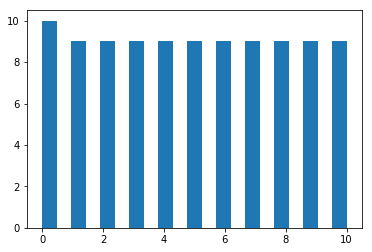

In [15]:
plt.hist(output, bins=2*divisions+1)

---
06.03

In [33]:
input_ = 13 * np.random.rand(10, 100)

output = np.empty_like(input_, dtype='uint8')
divisions = 4

for col_idx in range(input_.shape[0]):
    wrap_discretize.discretize(
        seed = 123,
        discretization_index = 4,
        feature_id = col_idx,  # ?
        divisions = divisions,
        object_count = input_.shape[1],
        py_in_data = input_[col_idx],
        py_sorted_in_data = np.sort(input_[col_idx]),
        py_out_data = output[col_idx],
        range_ = 0.01
    )

In [35]:
input_.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

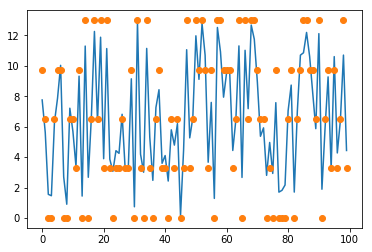

In [32]:
plt.plot(input_[0])
plt.plot(13 * output[0] / divisions, "o")
plt.show()

In [37]:
divisions = 1
range_ = 0.00
seed = 123

file = "madelon_tiny.csv"
input_ = []
with open(file) as csvfile:
    reader = csv.reader(csvfile, delimiter=',',
                        quoting=csv.QUOTE_NONNUMERIC)
    for row in reader:
        input_.append(row)
        
input_ = np.ascontiguousarray(np.array(input_, dtype='float64').T[:-1])
data = np.empty_like(input_, dtype='uint8')

input_.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [38]:
for col_idx in range(input_.shape[0] - 1):
    wrap_discretize.discretize(
        seed = 123,
        discretization_index = 4,
        feature_id = col_idx,  # ?
        divisions = divisions,
        object_count = input_.shape[1],
        py_in_data = input_[col_idx],
        py_sorted_in_data = np.sort(input_[col_idx]),
        py_out_data = data[col_idx],
        range_ = range_
    )

data[-1] = input_[-1:].astype('uint8')


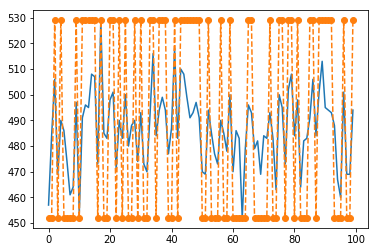

In [51]:
plt.plot(input_[0,:100])
plt.plot((data[0,:100] * (np.max(input_[0,:100])-np.min(input_[0,:100])) + np.min(input_[0,:100])) / divisions,"o--")
plt.show()